In [16]:
%matplotlib inline
import pymc as pm
import matplotlib.pyplot as plt
import scipy.stats as st
import arviz as az
import metropolis_commands as mc
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = [5, 3]

In [21]:
df = pd.read_csv("./Daten/chemical_shifts.csv",header=None)
df.head()

,0
0,51.06
1,55.12
2,53.73
3,50.24
4,52.05


## $ t $-Verteilung



In der Regel ziehen es Bayesianer vor, Annahmen über die Daten direkt im Modell zu kodieren, indem sie verschiedene Priors und Likelihoods verwenden, als mit Ad-hoc-Heuristiken wie Ausreisser-Entfernungsregeln zu arbeiten.

Eine sehr nützliche Option beim Umgang mit Ausreissern und Normalverteilungen ist es, die Gauss'sche Likelihood-Funktion durch eine Student's $t$-Verteilung zu ersetzen. Diese Verteilung hat drei Parameter: den Mittelwert, die Skala (analog zur Standardabweichung) und die Freiheitsgrade, die üblicherweise mit dem griechischen Buchstaben $ \nu  $ (nü) bezeichnet werden. Werte von $\nu$ können im Intervall $[0, \infty]$ variieren, siehe folgende Abbildung.

(-5.0, 5.0)

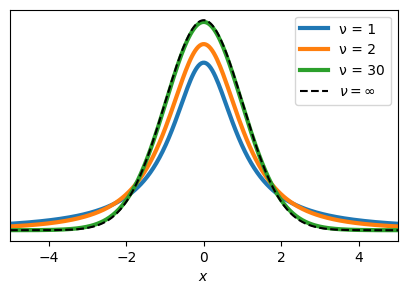

In [17]:
plt.figure(figsize=(5, 3))
x_values = np.linspace(-10, 10, 500)
for df in [1, 2, 30]:
    distri = st.t(df)
    x_pdf = distri.pdf(x_values)
    plt.plot(x_values, x_pdf, label=fr'ν = {df}', lw=3)
x_pdf = st.norm.pdf(x_values)
plt.plot(x_values, x_pdf, 'k--', label=r'$ν = \infty$')
plt.xlabel('$x$')
plt.yticks([])
plt.legend()
plt.xlim(-5, 5)

Für einen Wert von $ \nu=1 $ erhalten wir eine Verteilung mit sehr starken Ausläufern (Schwänzen), die auch als Cauchy- oder Lorentz-Verteilung bekannt ist. Letztere ist besonders unter Physikern beliebt. Mit starken Ausläufern ist es wahrscheinlicher, Werte zu finden, die weit vom Mittelwert entfernt sind. Die Werte sind nicht so stark um den Mittelwert konzentriert wie bei einer  Gauss-Verteilung. Zum Beispiel sind 95\% der Werte einer Cauchy-Verteilung zwischen $-12.7$ und $12.7$ zu finden. Bei einer Gauss-Verteilung (mit einer Standard
Abweichung von eins) befinden sich  95\% der Werte zwischen $-1.96$ und $1.96$. 

Wir werden das vorherige Modell umschreiben, indem wir die Gauss-Verteilung durch die 
Student's t-Verteilung ersetzen:

\begin{align*}
\mu &\sim \text{Uniform}(t_{\mu},h_{\mu})\\
\sigma &\sim |\mathcal{N}(0,\sigma_{h}^{2})|\\
\nu&\sim \text{Exp}(\lambda)\\
y&\sim\mathcal{T}(\mu,\sigma,\nu)
\end{align*}

Da die Student's $t$-Verteilung einen Parameter ($ \nu $) mehr hat als die Gauss-Verteilung, müssen wir einen weiteren Prior angeben. Wir wählen eine Exponentialverteilung mit einem Mittelwert von $30$. Aus der Abbildung mit den t-Verteilungen ist ersichtlich, dass eine Student's $t$-Verteilung  mit $ \nu=30 $ ziemlich
ähnlich wie eine Gauss-Verteilung aussieht (auch wenn sie es nicht ist). 

Der Exponential-Prior mit einem Mittelwert von 30 ist ein schwach informativer Prior, der dem Modell sagt, dass wir
mehr oder weniger denken, dass der Wert von $\nu$ um 30 herum sein sollte, sich aber mit Leichtigkeit zu kleineren und grösseren Werten bewegen kann. 

Wie üblich erlaubt uns `PyMC`, Modelle (neu) zu schreiben, indem wir die entsprechenden Prior-Verteilungen hinzufügen. Wir sollten allerdings aufpassen, dass die Exponential-Verteilung  in `PyMC` mit dem Kehrwert des Mittelwertes parametrisiert ist.

Wie üblich erlaubt uns `PyMC`, Modelle (neu) zu schreiben, indem wir die entsprechenden Prior-Verteilungen hinzufügen. Wir sollten allerdings aufpassen, dass die Exponential-Verteilung  in `PyMC` mit dem Kehrwert des Mittelwertes parametrisiert ist.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ, ν]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


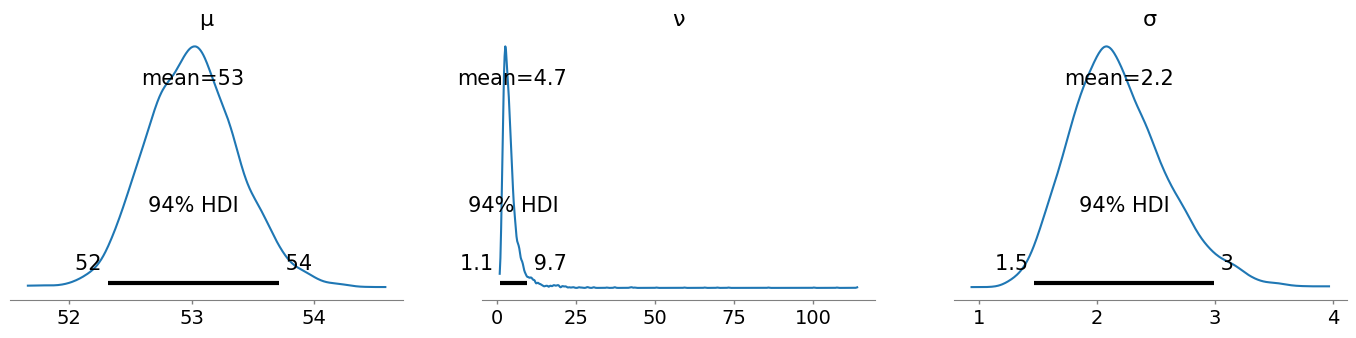

In [22]:
with pm.Model() as model_t:
    μ = pm.Uniform('μ', 40, 75)
    σ = pm.HalfNormal('σ', sigma=10)
    ν = pm.Exponential('ν', 1/30)
    y = pm.StudentT('y', nu=ν, mu=μ, sigma=σ, observed=df)
    trace_t = pm.sample(random_seed=4591)
    
az.plot_posterior(trace_t);

Posterior-Verteilungen sind für die drei Parameter $\mu$, $\sigma $ und $\nu$ dargestellt. Im Folgenden ist die Zusammenfassung der Kenngrössen der Verteilungen aufgeführt.

In [23]:
az.summary(trace_t)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ,53.011,0.380,52.315,53.716,0.007,0.005,2611.0,2592.0,1.0
ν,4.712,5.092,1.084,9.710,0.165,0.117,1730.0,1475.0,1.0
σ,2.191,0.412,1.472,2.988,0.010,0.007,1759.0,1791.0,1.0


Vergleichen wir die Posterior-Verteilungen von `model_g` mit den Posterior-Verteilungen von `model_t` und ebenso die Zusammenfassung der Kenngrössen von `model_t` mit der von `model_g`, so stellen wir Folgendes fest: Die Schätzungen der beiden Modelle für $ \mu $ sind ähnlich, mit einem Unterschied von $ \approx 0.5$. Die Schätzung von $ \sigma $ ändert sich von  $\approx 3.5$ auf $ \approx 2.2 $. Dies ist eine Folge der Wahl der Student's $t$-Verteilung als Likelihood-Funktion, welche den Werten, die vom Mittelwert abweichen, weniger Gewicht verleiht. Wir beobachten ebenfalls, dass wir nun eine _nicht sehr Gauss-ähnliche Verteilung_ mit ausgeprägteren Schwänzen erhalten haben.



Die Student's $t$-Verteilung ermöglicht uns eine _robustere_ Schätzung, da die Ausreisser den Effekt haben,  $ \nu $ zu verringern, was dann dazu führt, dass sich die Standardabweichung erhöht. Der Mittelwert und die Skala ("Standardabweichung" der t-Verteilung) werden also geschätzt, indem  die Grossmehrheit der Daten stärker gewichtet wird als diejenigen Werte, welche sich außerhalb der Masse befinden. 
